### Exploratory Data Analysis (EDA):

EDA helps us understand the data and its characteristics. We'll begin by importing the necessary libraries and loading the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('BrentOilPrices.csv')

In [2]:
# Display the first few rows of the dataset
df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [3]:
# Check the shape of the dataset
print(df.shape)

(9011, 2)


In [4]:
# Check the data types of each column
print(df.dtypes)

Date      object
Price    float64
dtype: object


### Convert Date to Index Column:

To perform forecasting, we'll convert the date column into the index column. This step helps us align the data properly for time-series analysis.

In [5]:
# Convert 'Date' column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' column as the index
df.set_index('Date', inplace=True)

In [6]:
# Check the data types of each column
index_type = df.index.dtype

print("Index data type:", index_type)

print(df.dtypes)

Index data type: datetime64[ns]
Price    float64
dtype: object


In [7]:
df.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


In [8]:
#Find null values
df.isnull().sum()

Price    0
dtype: int64

In [9]:
#Find the duplicates
df.duplicated().sum()

3996

### Visualization:

Visualizing the data helps us gain insights and identify any patterns or trends. We'll plot the time series to observe the fluctuations in the Brent crude oil prices.

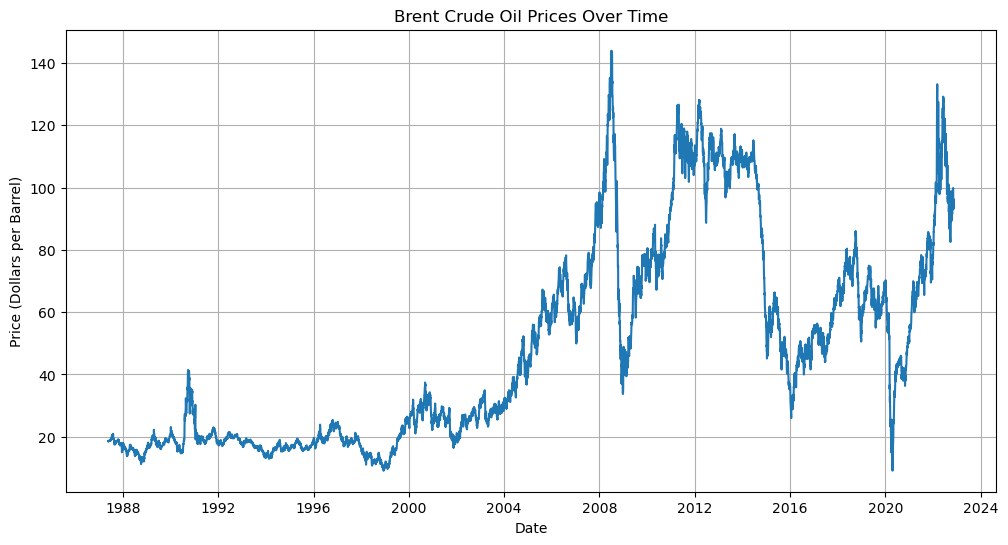

In [10]:
# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'])
plt.title('Brent Crude Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (Dollars per Barrel)')
plt.grid(True)
plt.show()

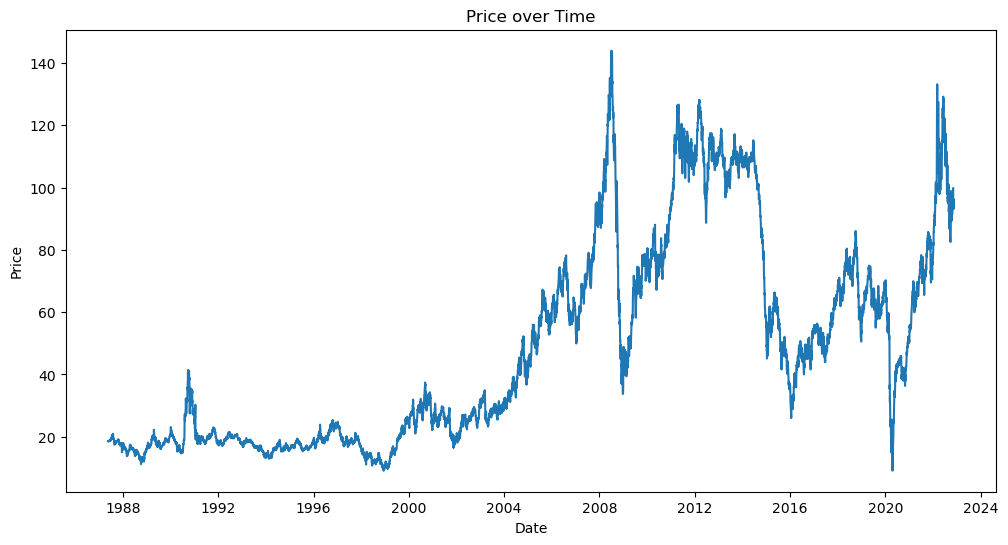

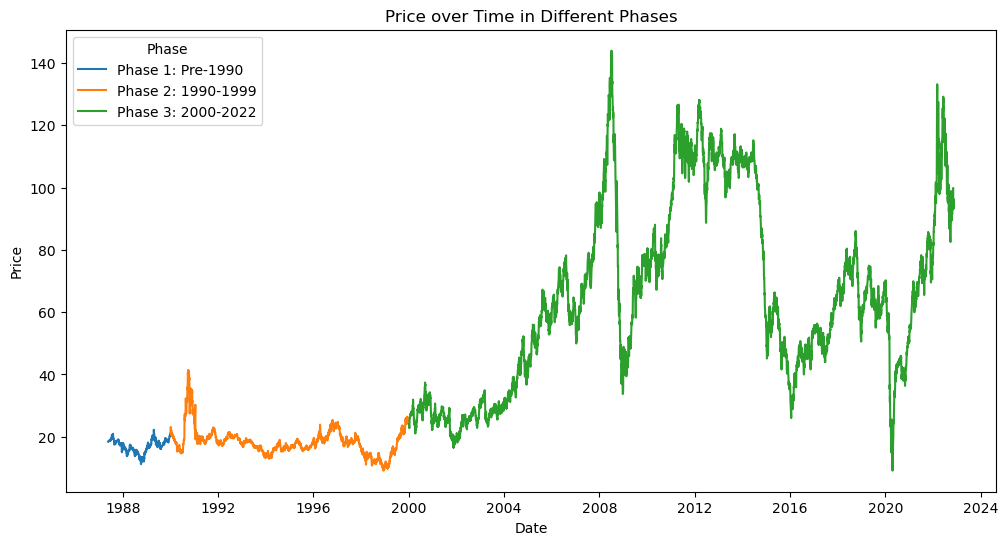

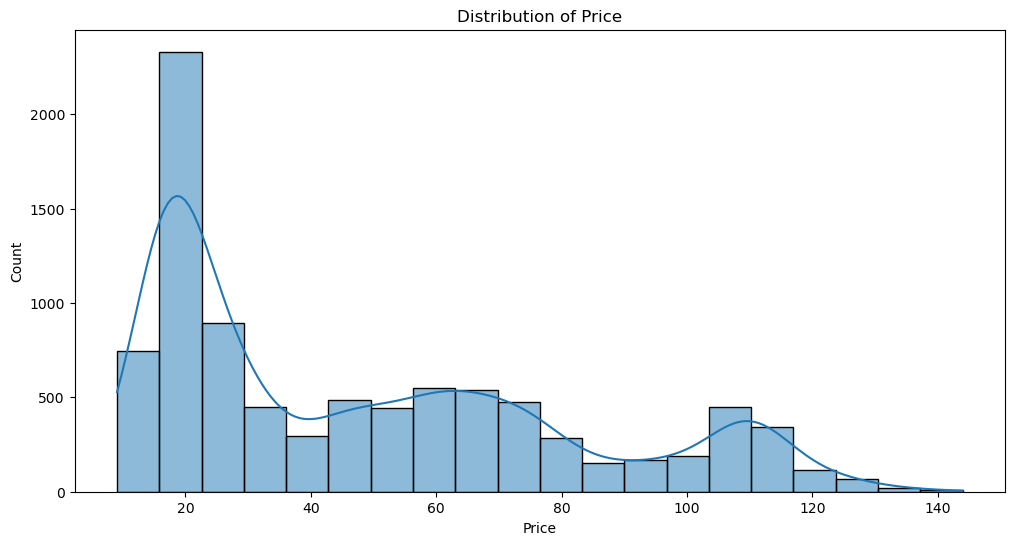

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Line Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y='Price', data=df)
plt.title('Price over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Plot through different phases
plt.figure(figsize=(12, 6))
df['Phase'] = pd.cut(df.index, bins=pd.to_datetime(['1987-05-20', '1990-01-01', '1999-12-31', '2022-12-19']), 
                     labels=['Phase 1: Pre-1990', 'Phase 2: 1990-1999', 'Phase 3: 2000-2022'])
sns.lineplot(x=df.index, y='Price', hue='Phase', data=df)
plt.title('Price over Time in Different Phases')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Price', bins=20, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


### Stationarity Check:

Stationarity is an important assumption for time-series forecasting models. We'll check if the data is stationary or non-stationary. Stationary data has constant mean, variance, and autocovariance over time.

In [12]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(df['Price'])

# Extract the p-value from the test results
p_value = result[1]

if p_value > 0.05:
    print("The data is non-stationary.")
else:
    print("The data is stationary.")

The data is non-stationary.


The code performs the Augmented Dickey-Fuller (ADF) test on the time series and checks the p-value. If the p-value is greater than 0.05, the data is considered non-stationary.

### Converting Non-Stationary Data into Stationary:

If the data is non-stationary, we need to transform it into a stationary series. We will be using differencing and logarithmic transformations.

### a. Differencing:

Differencing involves subtracting the previous observation from the current one. It helps remove trends or seasonality.

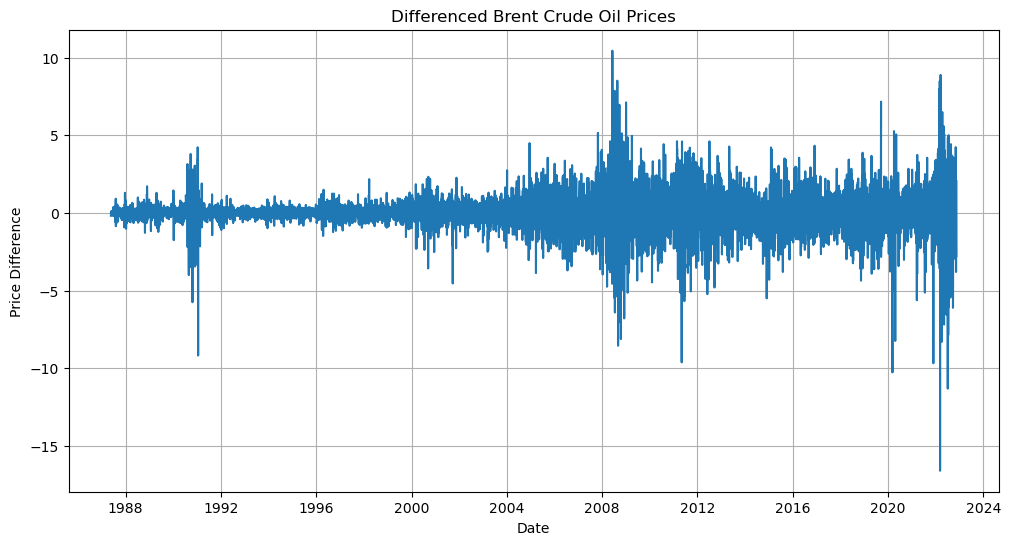

,Price,PriceDiff
Date,,
1987-05-20,18.63,NaN
1987-05-21,18.45,-0.18
1987-05-22,18.55,0.10
1987-05-25,18.60,0.05
1987-05-26,18.63,0.03
...,...,...
2022-11-08,96.85,-3.02
2022-11-09,93.05,-3.80
2022-11-10,94.25,1.20


In [13]:
# Perform differencing to make the data stationary
df['PriceDiff'] = df['Price'].diff()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['PriceDiff'])
plt.title('Differenced Brent Crude Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.grid(True)
plt.show()
df = df.drop('Phase',axis=1)
display(df)

The code computes the differenced series by subtracting the previous observation from the current one. Then, it plots the differenced series.

##  ANAMOLY DETECTION AND TREATMENT


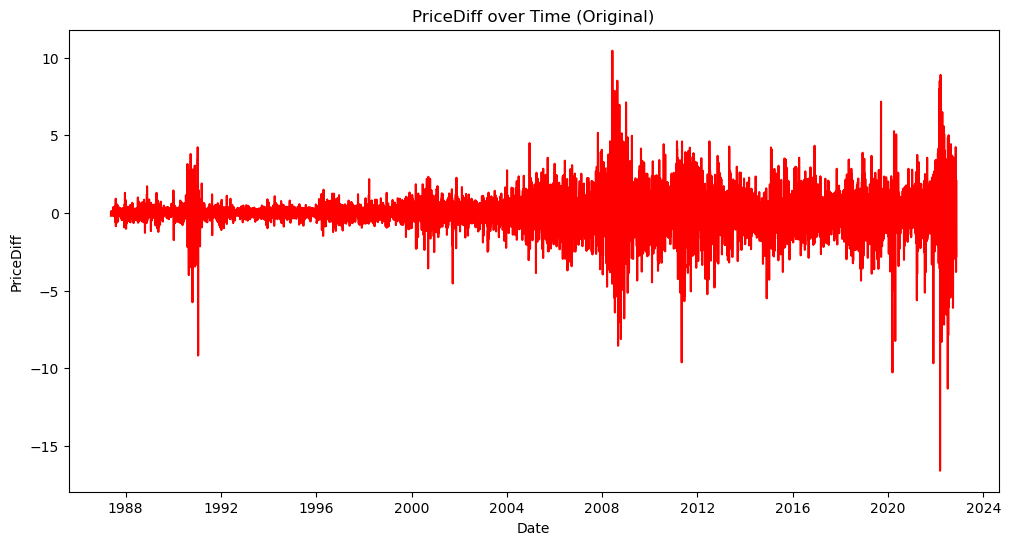

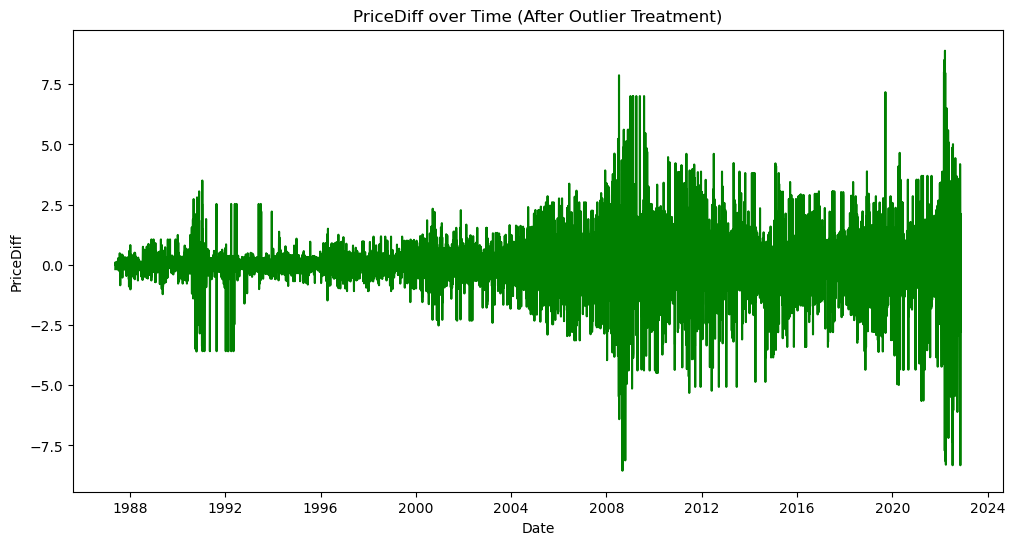

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Data = df.copy()
# Plotting the original data
plt.figure(figsize=(12, 6))
sns.lineplot(x=Data.index, y='PriceDiff', data=Data, color='red')
plt.title('PriceDiff over Time (Original)')
plt.xlabel('Date')
plt.ylabel('PriceDiff')
plt.show()

# Calculate IQR for the past 12 months
rolling_iqr = Data['PriceDiff'].rolling(window=12).quantile(0.75) - Data['PriceDiff'].rolling(window=12).quantile(0.25)

# Find outliers using the new IQR
outliers_upper = Data['PriceDiff'] > (Data['PriceDiff'].rolling(window=12).quantile(0.75) + 1.5 * rolling_iqr)
outliers_lower = Data['PriceDiff'] < (Data['PriceDiff'].rolling(window=12).quantile(0.25) - 1.5 * rolling_iqr)

# Replace outliers with the border values of the IQR
Data['PriceDiff_cleaned'] = Data['PriceDiff'].copy()
Data.loc[outliers_upper, 'PriceDiff_cleaned'] = Data.loc[outliers_upper, 'PriceDiff'].rolling(window=12).quantile(0.75)
Data.loc[outliers_lower, 'PriceDiff_cleaned'] = Data.loc[outliers_lower, 'PriceDiff'].rolling(window=12).quantile(0.25)

# Plotting the data after outlier treatment
plt.figure(figsize=(12, 6))
sns.lineplot(x=Data.index, y='PriceDiff_cleaned', data=Data, color='green')
plt.title('PriceDiff over Time (After Outlier Treatment)')
plt.xlabel('Date')
plt.ylabel('PriceDiff')
plt.show()

# Dropping the 'PriceDiff' column and renaming the 'PriceDiff_cleaned' column
Data_cleaned = Data.drop('PriceDiff', axis=1).rename(columns={'PriceDiff_cleaned': 'PriceDiff'})

# Remove rows with missing values
Data_cleaned = Data_cleaned.dropna()

# Reset the index
Data_cleaned = Data_cleaned.reset_index()

# Removing the 'RollingIQR' column
#Data_cleaned = Data_cleaned.drop('RollingIQR', axis=1)


In [15]:
Data_cleaned

,Date,Price,PriceDiff
0,1987-05-21,18.45,-0.1800
1,1987-05-22,18.55,0.1000
2,1987-05-25,18.60,0.0500
3,1987-05-26,18.63,0.0300
4,1987-05-27,18.60,-0.0300
...,...,...,...
8983,2022-11-08,96.85,-8.3225
8984,2022-11-09,93.05,-3.8000
8985,2022-11-10,94.25,1.2000
8986,2022-11-11,96.37,2.1200


In [16]:
# Convert 'Date' column to datetime type
Data_cleaned['Date'] = pd.to_datetime(Data_cleaned['Date'])

# Set 'Date' column as the index
Data_cleaned.set_index('Date', inplace=True)

Data_cleaned

,Price,PriceDiff
Date,,
1987-05-21,18.45,-0.1800
1987-05-22,18.55,0.1000
1987-05-25,18.60,0.0500
1987-05-26,18.63,0.0300
1987-05-27,18.60,-0.0300
...,...,...
2022-11-08,96.85,-8.3225
2022-11-09,93.05,-3.8000
2022-11-10,94.25,1.2000


# Model Building:
We'll build and evaluate different forecasting models to select the best one. We will be using ARIMA, SARIMA, and LSTM.

## a. ARIMA Model:
The ARIMA (Autoregressive Integrated Moving Average) model is suitable for univariate time-series forecasting. It combines autoregression, moving average, and differencing.

In [17]:
# Split the data into train and test sets
train_size = int(len(Data_cleaned) * 0.8)
train_data, test_data = Data_cleaned[:train_size], Data_cleaned[train_size:]

In [18]:
test_data

,Price,PriceDiff
Date,,
2015-10-26,46.57,0.2700
2015-10-27,45.54,-1.0300
2015-10-28,47.60,2.7350
2015-10-29,48.04,0.4400
2015-10-30,48.00,-0.0400
...,...,...
2022-11-08,96.85,-8.3225
2022-11-09,93.05,-3.8000
2022-11-10,94.25,1.2000


In [19]:
#!pip install prophet

C:\Users\finaz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\finaz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\finaz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\finaz\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\finaz\a

RMSE: 1.66545223164152
MAE: 1.1476015021302277


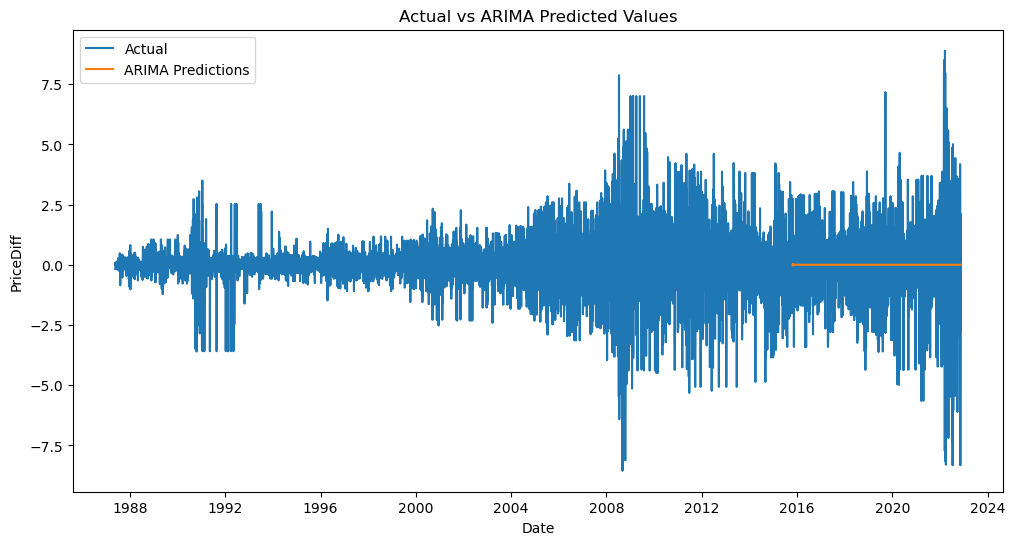

In [20]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Selecting only the 'PriceDiff' column from train_data
train_price = train_data['PriceDiff']

# Fit ARIMA model
arima_model = ARIMA(train_price, order=(2, 1, 2))
arima_model_fit = arima_model.fit()

# Forecast using ARIMA model
arima_predictions = arima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Calculate performance metrics
arima_rmse = np.sqrt(mean_squared_error(test_data.loc[:, 'PriceDiff'], arima_predictions))
arima_mae = mean_absolute_error(test_data.loc[:, 'PriceDiff'], arima_predictions)

print("RMSE:", arima_rmse)
print("MAE:", arima_mae)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(Data_cleaned.index, Data_cleaned['PriceDiff'], label='Actual')
plt.plot(test_data.index, arima_predictions, label='ARIMA Predictions')
plt.title('Actual vs ARIMA Predicted Values')
plt.xlabel('Date')
plt.ylabel('PriceDiff')
plt.legend()
plt.show()


## SARIMA

C:\Users\finaz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\finaz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\finaz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


RMSE: 1.6703647827632122
MAE: 1.1583826631123408


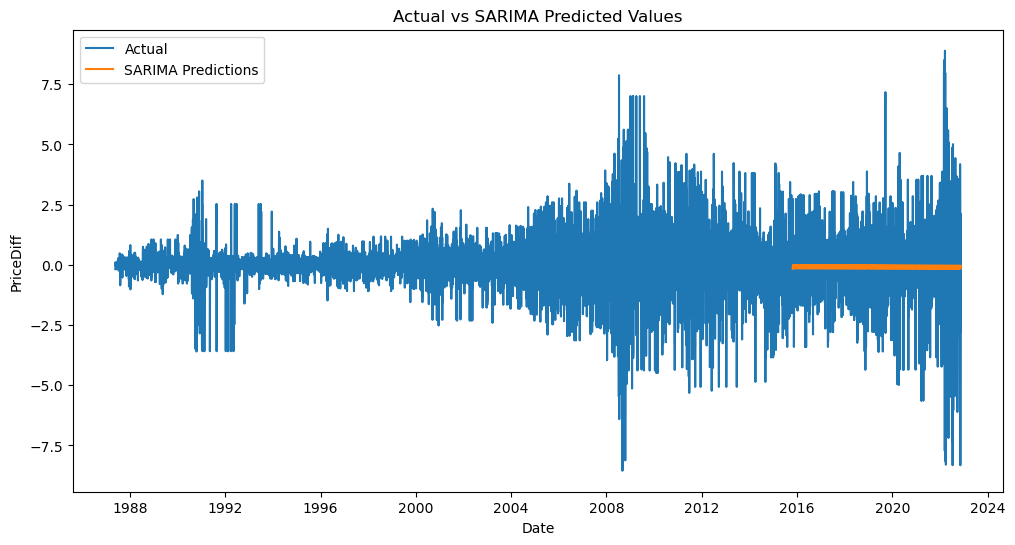

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model
sarima_model = SARIMAX(train_price, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Fit the SARIMA model
sarima_model_fit = sarima_model.fit()

# Forecast using SARIMA model
sarima_predictions = sarima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Calculate performance metrics
sarima_rmse = np.sqrt(mean_squared_error(test_data.loc[:, 'PriceDiff'], sarima_predictions))
sarima_mae = mean_absolute_error(test_data.loc[:, 'PriceDiff'], sarima_predictions)

print("RMSE:", sarima_rmse)
print("MAE:", sarima_mae)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(Data_cleaned.index, Data_cleaned['PriceDiff'], label='Actual')
plt.plot(test_data.index, sarima_predictions, label='SARIMA Predictions')
plt.title('Actual vs SARIMA Predicted Values')
plt.xlabel('Date')
plt.ylabel('PriceDiff')
plt.legend()
plt.show()


## c.LSTM

In [22]:
Data_cleaned

,Price,PriceDiff
Date,,
1987-05-21,18.45,-0.1800
1987-05-22,18.55,0.1000
1987-05-25,18.60,0.0500
1987-05-26,18.63,0.0300
1987-05-27,18.60,-0.0300
...,...,...
2022-11-08,96.85,-8.3225
2022-11-09,93.05,-3.8000
2022-11-10,94.25,1.2000


In [23]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


Epoch 1/20
225/225 [==============================] - 11s 19ms/step - loss: 0.0096
Epoch 2/20
225/225 [==============================] - 4s 19ms/step - loss: 0.0040
Epoch 3/20
225/225 [==============================] - 3s 14ms/step - loss: 0.0040
Epoch 4/20
225/225 [==============================] - 2s 11ms/step - loss: 0.0040
Epoch 5/20
225/225 [==============================] - 3s 11ms/step - loss: 0.0040
Epoch 6/20
225/225 [==============================] - 2s 9ms/step - loss: 0.0041
Epoch 7/20
225/225 [==============================] - 3s 11ms/step - loss: 0.0040
Epoch 8/20
225/225 [==============================] - 3s 12ms/step - loss: 0.0039
Epoch 9/20
225/225 [==============================] - 3s 12ms/step - loss: 0.0039
Epoch 10/20
225/225 [==============================] - 3s 12ms/step - loss: 0.0040
Epoch 11/20
225/225 [==============================] - 3s 12ms/step - loss: 0.0039
Epoch 12/20
225/225 [==============================] - 3s 12ms/step - loss: 0.0039
Epoch 13/20
2

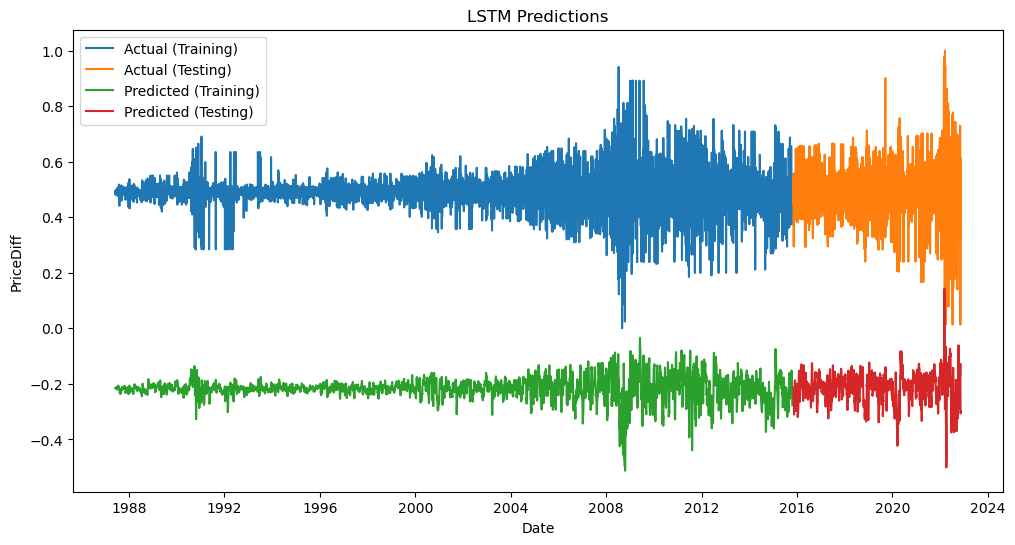

Training RMSE: 0.7114593823293157
Training MSE: 0.5061744527044114
Training MAE: 0.7077094023678258
Testing RMSE: 0.7159420496084142
Testing MSE: 0.512573018397497
Testing MAE: 0.7071346788236761


In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Preprocess the data
scaled_data = scaler.fit_transform(Data_cleaned[['PriceDiff']])

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare the data for LSTM
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:i+time_steps])
        y.append(dataset[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 10  # Number of time steps to consider
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))

# Compile and train the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

# Save the model using Keras' save method
model_path = "lstm_model.h5"
lstm_model.save(model_path)

# Load the saved LSTM model
model = load_model(model_path)

# Make predictions
train_predictions = lstm_model.predict(X_train)
test_predictions = lstm_model.predict(X_test)

# Inverse scale the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)

# Save the model using joblib
#import joblib
#Fuelmodel = "lstm_model.joblib"
#joblib.dump(lstm_model, Fuelmodel)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(Data_cleaned.index[time_steps:train_size], y_train, label='Actual (Training)')
plt.plot(Data_cleaned.index[train_size+time_steps:], y_test, label='Actual (Testing)')
plt.plot(Data_cleaned.index[time_steps:train_size], train_predictions, label='Predicted (Training)')
plt.plot(Data_cleaned.index[train_size+time_steps:], test_predictions, label='Predicted (Testing)')
plt.title('LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('PriceDiff')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error


# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mse = mean_squared_error(y_train, train_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)

test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mse = mean_squared_error(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

# Print performance metrics
print("Training RMSE:", train_rmse)
print("Training MSE:", train_mse)
print("Training MAE:", train_mae)

print("Testing RMSE:", test_rmse)
print("Testing MSE:", test_mse)
print("Testing MAE:", test_mae)



In [30]:
# Convert Data_cleaned to CSV with index
Data_cleaned.to_csv("Cleaned_data.csv")

# Read the CSV file with index column
cleaned_data = pd.read_csv("Cleaned_data.csv", index_col="Date")

# Print the contents of the DataFrame
cleaned_data


,Price,PriceDiff
Date,,
1987-05-21,18.45,-0.1800
1987-05-22,18.55,0.1000
1987-05-25,18.60,0.0500
1987-05-26,18.63,0.0300
1987-05-27,18.60,-0.0300
...,...,...
2022-11-08,96.85,-8.3225
2022-11-09,93.05,-3.8000
2022-11-10,94.25,1.2000
